In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from operator import itemgetter
import seaborn as sns

In [2]:
def add_data_info():
    df1 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points-from-2017.csv', encoding= 'unicode_escape', low_memory=False)
    df2 = pd.read_csv('raw_data/charting-m-matches.csv', encoding= 'unicode_escape', low_memory=False)
    
    #get separated values from m-matches list of games - based on matchid
    df = pd.merge(df1,df2[['match_id','Date','Tournament','Round','Surface','Player 1','Player 2']], on=['match_id'], how='left')
    
    #add the condition of "Grand Slam" - 5 or 3 sets
    conditions = df['Tournament'].isin(["Wimbledon", "Australian Open", "US Open", "Roland Garros"])
    values = [1,0]

    # Create a new column  based on the conditions and values
    df['Grand Slam'] = pd.Series(pd.NA)
    df.loc[conditions, 'Grand Slam'] = values[0]
    df.loc[~conditions, 'Grand Slam'] = values[1]
    
    # save the original dataset with enriched data for future features
    df.to_csv('raw_data/charting-m-points-from-2017-enriched.csv', index=False)

In [3]:
def filter_player(df,opponent):
    
    # Read the dataset into a pandas DataFrame - from enriched file
    df = pd.read_csv(df, encoding= 'unicode_escape', low_memory=False)
    
    ## filtra pelo  oponente
    df = df[(df["Player 1"].str.contains(opponent)) | (df["Player 2"].str.contains(opponent))].copy()
    
    ##define se está sacando e se ganhou o ponto
    df['i_serve'] = np.where(((df['Svr'] == 1) & (df['Player 1'] == opponent )) | ((df['Svr'] == 2) & (df['Player 2'] == opponent)), 0, 1)
    df['i_win'] = np.where(((df['isSvrWinner'] == df['i_serve'])), 1, 0)
    df['is_second_service'] = np.where(((df['2nd'].isnull())), 0, 1)
    
    ## direção do saque
    # primeiro caractere do segundo saque
    df['dir_srv'] = df.loc[:, '2nd'].str[0]
    ## completa com o primeiro caractere do primeiro saque quando ele entrou
    df['dir_srv'].fillna(df.loc[:, '1st'].str[0], inplace=True)

    
    ##reseta o indice
    df.reset_index(inplace=True)
    
    ## salva arquivo e retorna dataset da funcao
    csv_file = "raw_data/" + opponent + "_points.csv"
    df.to_csv(csv_file, index=False)
    return df

In [4]:
meaning_char = pd.read_csv('https://raw.githubusercontent.com/eduardoscovino/tennis-analytics/master/code_map.csv',
                           encoding= 'unicode_escape', sep=';')

In [5]:
add_data_info()

In [6]:
df = filter_player('raw_data/charting-m-points-from-2017-enriched.csv','Novak Djokovic')

In [7]:
## serve direction encode 
df = df[df['dir_srv'].isin(['4','5','6'])]

## to numeric for rallyCount and serve direction
df['rallyCount']=pd.to_numeric(df['rallyCount'])
df['dir_srv']=pd.to_numeric(df['dir_srv'])

In [8]:
#Spliting Serve and Return
df['rally_desc'] = df.loc[:, '2nd']
df['rally_desc'].fillna(df.loc[:, '1st'], inplace=True)

##df['Serve'] = df.loc[:, 'rally_desc'].str[0:1]

df['rally_desc'] = df['rally_desc'].str[1:]

sc = np.array(meaning_char[~meaning_char['code'].isin(['f', 'b', 'r', 's', 'v', 'l', 'o', 'z', 'p', 'u', 'y', 'h', 'i', 'j', 'k','m', '1', '2', '3', '7', '8', '9'])]['code'])

#Spliting every shot
df['rally_desc'] = df['rally_desc'].apply(lambda x: ''.join([c for c in x if c not in sc]))
df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r').str.replace('v',' v').str.replace('l',' l').str.replace('o',' o').str.replace('z',' z').str.replace('p',' p').str.replace('u',' u').str.replace('y',' y').str.replace('h',' h').str.replace('i',' i').str.replace('j',' j').str.replace('k',' k').str.replace('m',' m').str.replace('!','').str.replace('+','').str.replace(';','').str.replace('^','').str.replace('C','')
df['rally_desc'] = df['rally_desc'].map(lambda x: x.lstrip(' ').rstrip(' '))

In [9]:
df['rally_tratada'] = (df['rallyCount']/2).apply(np.floor)

In [10]:
df.head(20)

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,rally_tratada
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,3.0
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,0.0
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,False,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,0.0
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,0.0
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,6.0
5,642,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,6,0,0,1,0,0-0,2 (1),1,0,NaN,2,1,CR,4n,6b37b2f3s2f1f1f3w@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,1,7,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,6,b37 b2 f3 s2 f1 f1 f3,3.0
6,643,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,7,0,0,1,0,15-0,2 (2),1,0,NaN,2,1,CR,4n,5b38s3b3b3b3b3b1*,NaN,0,0.0,0,1.0,False,False,True,False,False,False,1,0,8,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,b38 s3 b3 b3 b3 b3 b1,4.0
7,644,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,8,0,0,1,0,15-15,2 (3),1,0,NaN,2,1,CR,6n,5f28f3s2f+3b2v1d@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,5,f28 f3 s2 f3 b2 v1,3.0
8,645,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,9,0,0,1,0,15-30,2 (4),1,0,NaN,2,1,CR,4d,6f38f3b2f1f2f3d@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,0,1,6,f38 f3 b2 f1 f2 f3,3.0
9,646,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,10,0,0,1,0,15-40,2 (5),1,0,NaN,2,1,CR,6d,5b3w@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,1,1,1,5,b3,0.0


### Adição da coluna how_ended

In [11]:
# df['end']
df['how_ended'] = df.loc[:, '2nd'].str[-1]
df['how_ended'].fillna(df.loc[:, '1st'].str[-1], inplace=True)

df.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,rally_tratada,how_ended
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,3.0,@
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,0.0,#
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,False,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,0.0,*
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,0.0,@
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,6.0,#


In [12]:
# vamos entender melhor isso aqui

df['how_ended'].value_counts()

how_ended
#    6264
*    6054
@    5820
d     267
n     249
w      66
x      14
C      13
;       4
Name: count, dtype: int64

In [13]:
df['isUnforced'] = df['isUnforced'].replace({True: 1, False: 0})
df['isForced'] = df['isForced'].replace({True: 1, False: 0})
df['serve_return'] = df['rally_desc'].map(lambda x: x.split(' ')).str[0]

## Dataset finalizado ##

In [14]:
df['serve_return'].nunique()

86

In [15]:
df['how_ended'].nunique()

9

In [16]:
#df = df[df['serve_return']!=""]

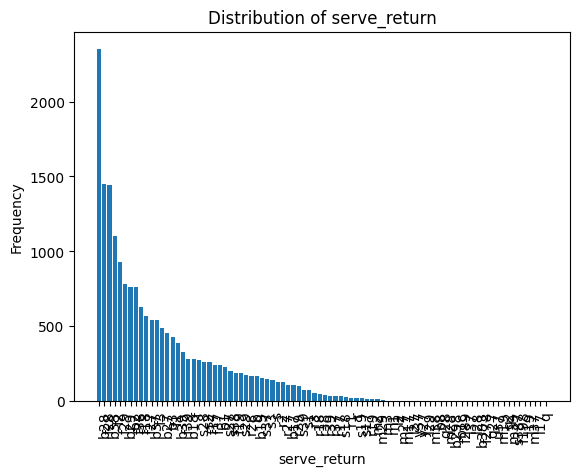

In [17]:
serve_return_column = df["serve_return"]
value_counts = serve_return_column.value_counts()

plt.bar(value_counts.index, value_counts.values )
plt.xlabel("serve_return")
plt.ylabel("Frequency")
plt.title("Distribution of serve_return")
plt.xticks(rotation=90)
plt.show()

In [18]:
serve_return_counts = df["serve_return"].value_counts().reset_index()
serve_return_counts.columns = ["serve_return", "frequency"]
serve_return_counts = serve_return_counts.sort_values("frequency", ascending=False )

serve_return_counts.head(10)


,serve_return,frequency
0,,2348
1,b28,1453
2,f28,1443
3,b38,1105
4,f2,927
5,f29,782
6,b29,766
7,b2,761
8,f38,627
9,f18,567


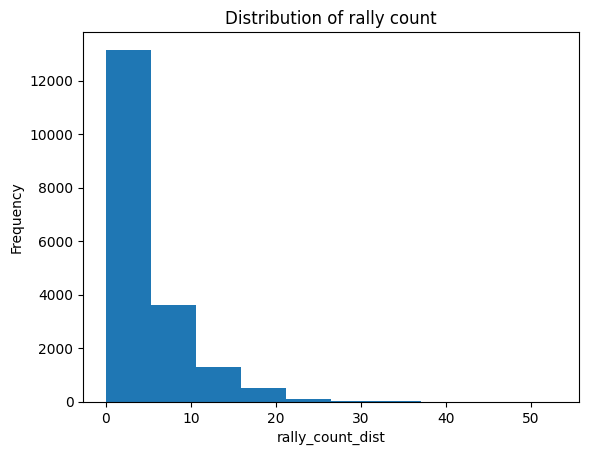

In [19]:
rally_count_dist = df["rallyCount"]
rally_count_dist = rally_count_dist.dropna()

plt.hist(rally_count_dist)
plt.xlabel("rally_count_dist")
plt.ylabel("Frequency")
plt.title("Distribution of rally count")
plt.show()

In [20]:
rally_counts = df["rallyCount"].value_counts().reset_index()
rally_counts.columns = ["rally_counts", "frequency"]
rally_counts = rally_counts.sort_values("frequency", ascending=False )

print(rally_counts)

    rally_counts  frequency
0              1       5127
1              3       2735
2              2       1753
3              5       1559
4              4       1377
5              6       1013
6              7        948
7              8        656
8              0        607
9              9        561
10            10        430
11            11        350
12            12        314
13            13        265
14            14        207
15            15        172
16            16        151
17            17        104
18            18         89
19            19         64
20            20         57
21            21         49
22            22         33
23            23         30
24            24         24
25            25         20
26            26          8
27            28          8
28            27          6
31            30          5
30            35          5
29            29          5
32            33          4
33            31          4
34            34    

## Geração das features

In [21]:
features = ['Surface',
            'Round',
            'Grand Slam',
            'i_serve',
            'is_second_service',
            'dir_srv',
            'rally_tratada',
            # 'rallyCount',
            'isUnforced',
            'isForced',
            "serve_return",
            "how_ended"
            ]
X = df[features]
y = df['i_win']

In [22]:
feat_categorical = ['Surface','Round','dir_srv','serve_return','how_ended']

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18751 entries, 0 to 19323
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Surface            18751 non-null  object 
 1   Round              18751 non-null  object 
 2   Grand Slam         18751 non-null  int64  
 3   i_serve            18751 non-null  int64  
 4   is_second_service  18751 non-null  int64  
 5   dir_srv            18751 non-null  int64  
 6   rally_tratada      18751 non-null  float64
 7   isUnforced         18751 non-null  int64  
 8   isForced           18751 non-null  int64  
 9   serve_return       18751 non-null  object 
 10  how_ended          18751 non-null  object 
dtypes: float64(1), int64(6), object(4)
memory usage: 1.7+ MB


## separação - treino, teste e validação

In [24]:
from sklearn.model_selection import train_test_split

# Train-Test Split - ## parametro stratify ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=1)

In [25]:
print(len(X_train), 'train examples')
print(len(X_test), 'test examples')

13125 train examples
5626 test examples


In [26]:
X_train['serve_return'].nunique()

79

## Inicio do modelo - pre processamento e encoder

In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display="diagram")

In [28]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=["object"]))
)

preproc

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14fb8c370>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14fb8cac0>)])

In [29]:
preproc.fit_transform(X_train).shape

(13125, 108)

In [30]:
X_train_preproc = preproc.fit_transform(X_train)
X_test_preproc = preproc.transform(X_test)

## Definição do modelo

In [31]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]} 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train_preproc, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [33]:
gb = gb_cv.best_estimator_

In [34]:
gb

GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=5,
                           random_state=5)

## Resultado final / evaluate

In [35]:
def plot_auc(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_preproc)[:,1]) #test AUC
    plt.figure(figsize=(5,4))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train_preproc)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test_preproc)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train_preproc)[:,1])
    plt.legend()
    plt.title('Curva ROC')
    print('AUC score é %.2f em dados de teste e %.2f em dados de treinamento.'%(auc_test, auc_train))
    plt.show()
    
def plot_conf_matrix(model):
    fig, ax = plt.subplots(figsize=(5,4))
    cm = confusion_matrix(y_test, model.predict(X_test_preproc))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    ax.xaxis.set_ticklabels(['Derrota', 'Vitória'])
    ax.yaxis.set_ticklabels(['Derrota', 'Vitória']);
    ax.set_xlabel('Labels reais')
    ax.set_ylabel('Labels preditas')
    ax.set_title('Matriz de confusão')
    plt.show()

**O que é curva ROC?**

    ROC é uma curva de probabilidade e AUC representa o quão bem o modelo conseguiu separar as 2 classes, no nosso caso 'Vitória' e 'Derrota'. Quanto mais perto do canto superior esquerdo passa a cuva ROC no gráfico, melhor o desempenho dele, e, quanto maior o valor AUC, melhor o modelo é em prever corretamente essas classes.

AUC score é 0.84 em dados de teste e 0.92 em dados de treinamento.


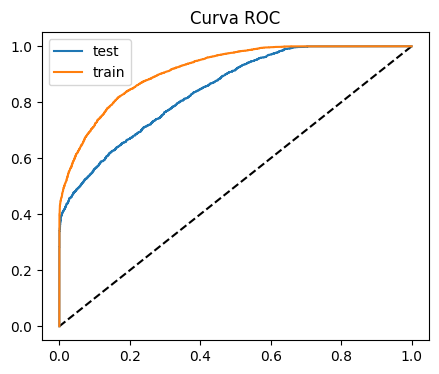

In [36]:
plot_auc(gb_cv.best_estimator_)

**O que é matriz de confusão?**
    
    É uma visualização usada para analisar o desempenho de um classificador, contando as vezes em que o rótulo real e o rótulo previsto são iguais.
    Nesse sentido, quanto maiores os valores na diagonal melhor, pois representa os casos que ambos rótulos reais e preditos foram definidos como "Vitória" ou ambos foram definidos como "Derrota".

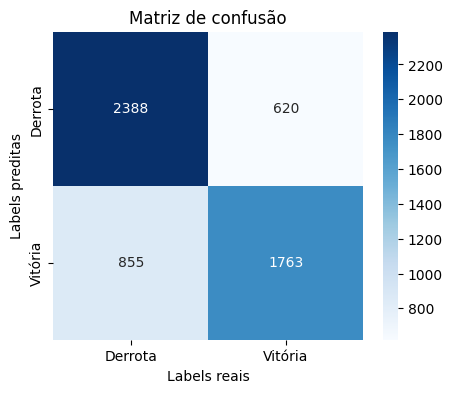

In [37]:
plot_conf_matrix(gb)

In [38]:
gb_cv.best_score_

0.7358476190476191

In [39]:
gb_final = gb_cv.best_estimator_

In [40]:
gb2 = gb.fit(X_train_preproc, y_train)

In [41]:
gb2.score(X_test_preproc, y_test)

0.7378243867756843

In [42]:
predictions = gb2.predict(X_test_preproc)

In [43]:
from sklearn.metrics import classification_report

In [44]:
classification_report(y_test, predictions, output_dict=True)

{'0': {'precision': 0.7363552266419982,
  'recall': 0.7938829787234043,
  'f1-score': 0.7640377539593665,
  'support': 3008},
 '1': {'precision': 0.7398237515736467,
  'recall': 0.673414820473644,
  'f1-score': 0.7050589882023595,
  'support': 2618},
 'accuracy': 0.7378243867756843,
 'macro avg': {'precision': 0.7380894891078225,
  'recall': 0.7336488995985242,
  'f1-score': 0.7345483710808629,
  'support': 5626},
 'weighted avg': {'precision': 0.7379692682827831,
  'recall': 0.7378243867756843,
  'f1-score': 0.7365926048744315,
  'support': 5626}}

https://www.statology.org/sklearn-classification-report/

referencia : aula House Kaggle

https://kitt.lewagon.com/camps/1166/challenges?path=05-ML%2F07-Ensemble-Methods%2F01-Houses-Kaggle-Competition

## Regressão 2

In [45]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [46]:
from xgboost import XGBRegressor